In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from src.utils import seed_everything
from src.datatest import IceCubeDatatest
from src.models import (
    IceCubeModel_RegA,
    IceCubeModel_RegB,
    IceCubeModel_ClsB
)

## functions

In [ ]:
def dict_to(x, device):
    return {k: x[k].to(device) for k in x}

In [ ]:
def xyz_to_angle(xyz):
    z_normed = xyz[:, 2] / torch.norm(xyz ,dim=1)
    x_normed = xyz[:, 0] / torch.norm(xyz[:, :2] ,dim=1)
    azimuth = ( torch.arccos(x_normed) * torch.sign(xyz[:, 1]) ) % (np.pi * 2)
    zenith = torch.arccos(z_normed)
    return torch.stack((azimuth, zenith),dim=1)

In [ ]:
def classes_to_angle(classes):
    # classes: [batch_size, 128] or [batch_size, 64], angle: [batch_size,]
    classes = F.log_softmax(classes, dim=1)
    max_index = torch.argmax(classes, dim=1)
    angle = (max_index / 128) * 2 * np.pi# angle = (max_index / 64) * np.pi
    return angle

In [ ]:
def competition_metric(pred, y):
    sa1 = torch.sin(pred[:, 0])
    ca1 = torch.cos(pred[:, 0])
    sz1 = torch.sin(pred[:, 1])
    cz1 = torch.cos(pred[:, 1])

    sa2 = torch.sin(y[:, 0])#sin(azimuth)
    ca2 = torch.cos(y[:, 0])
    sz2 = torch.sin(y[:, 1])#sin(zenith)
    cz2 = torch.cos(y[:, 1])

    scalar_prod = (
        ca1 * sz1 * ca2 * sz2 + sa1 * sz1 * sa2 * sz2 + cz1 * cz2
    ).clip(-1 + 1e-8, 1 - 1e-8)
    return torch.acos(scalar_prod).abs().float()

## load weight, then predict

In [ ]:
batch_id = 655
seed_everything(42)
model_path = './pretrained_model'
weight_name_RegA = 'S_RegA.pth'
weight_name_RegB = 'S_RegB.pth'
weight_name_ClsB = 'S_ClsB.pth'
preds_path = './preds'

In [ ]:
def load_predict(IceCubeModel, is_xyz_model, model_path, weight_name):
    # load
    icecube_model = IceCubeModel()
    weight = torch.load(os.path.join(model_path, weight_name))
    icecube_model.load_state_dict(weight)
    icecube_model.eval()
    icecube_model.to("cuda");
    # predict
    preds = torch.Tensor([]).to("cuda")
    if is_xyz_model:
        for x in tqdm(dataloader):
            with torch.no_grad():
                x = dict_to(x, "cuda")
                preds = torch.cat((preds, icecube_model(x)), dim=0)
    else:
        for x in tqdm(dataloader):
            with torch.no_grad():
                x = dict_to(x, "cuda")
                # predict each x
                pred = icecube_model(x)
                pred_azi = classes_to_angle(pred["azimuth"])
                pred_zen = classes_to_angle(pred["zenith"])
                pred = torch.stack((pred_azi, pred_zen), dim=1)
                # cat pred together
                preds = torch.cat((preds, pred), dim=0)
    # return
    return preds

## S-RegA

In [ ]:
# load dataset, 256
dataset = IceCubeDatatest(
    batch_id = batch_id,seq_length=256,
    train_path="./data/train",
    train_meta_path="./data/train_meta"
)
data_size = len(dataset)
indices = list(range(data_size))
batch_sampler = BatchSampler(
    torch.utils.data.SequentialSampler(indices),
    batch_size=8,# parallel processing
    drop_last=False
)
dataloader = DataLoader(
    dataset,
    num_workers=1,
    batch_sampler=batch_sampler
)

In [ ]:
preds_655_RegA = load_predict(
    IceCubeModel=IceCubeModel_RegA,is_xyz_model=True,
    model_path=model_path,weight_name=weight_name_RegA
)
torch.save(preds_655_RegA, os.path.join(preds_path, 'preds_655_RegA.pt'))

100%|██████████| 25000/25000 [30:02<00:00, 13.87it/s]


In [ ]:
preds_655_RegA = torch.load(os.path.join(preds_path, 'preds_655_RegA.pt'), map_location='cpu')
print(preds_655_RegA.shape)
preds_655_RegA = xyz_to_angle(preds_655_RegA)
print(preds_655_RegA.shape)

torch.Size([200000, 3])
torch.Size([200000, 2])


## S-RegB

In [ ]:
# load dataset, 196
dataset = IceCubeDatatest(
    batch_id = batch_id,seq_length=196,
    train_path="./data/train",
    train_meta_path="./data/train_meta"
)
data_size = len(dataset)
indices = list(range(data_size))
batch_sampler = BatchSampler(
    torch.utils.data.SequentialSampler(indices),
    batch_size=32,# parallel processing
    drop_last=False
)
dataloader = DataLoader(
    dataset,
    num_workers=1,
    batch_sampler=batch_sampler
)

In [ ]:
preds_655_RegB = load_predict(
    IceCubeModel=IceCubeModel_RegB,is_xyz_model=True,
    model_path=model_path,weight_name=weight_name_RegB
)
torch.save(preds_655_RegB, os.path.join(preds_path, 'preds_655_RegB.pt'))

100%|██████████| 6250/6250 [22:45<00:00,  4.58it/s]


In [ ]:
preds_655_RegB = torch.load(os.path.join(preds_path, 'preds_655_RegB.pt'), map_location='cpu')
print(preds_655_RegB.shape)
preds_655_RegB = xyz_to_angle(preds_655_RegB)
print(preds_655_RegB.shape)

torch.Size([200000, 3])
torch.Size([200000, 2])


## S-ClsB

In [ ]:
# load dataset, same as S-RegB

In [ ]:
preds_655_ClsB = load_predict(
    IceCubeModel=IceCubeModel_ClsB,is_xyz_model=False,
    model_path=model_path,weight_name=weight_name_ClsB
)
torch.save(preds_655_ClsB, os.path.join(preds_path, 'preds_655_ClsB.pt'))

100%|██████████| 6250/6250 [22:44<00:00,  4.58it/s]


In [ ]:
preds_655_ClsB = torch.load(os.path.join(preds_path, 'preds_655_ClsB.pt'), map_location='cpu')
print(preds_655_ClsB.shape)

torch.Size([200000, 2])


## voting rule

In [ ]:
def voting_rule_2preds(preds1,preds2,ratio_azi=0.73,threshold_azi=0.42,ration_zen=0.87,threshold_zen=0.56):
    # vote azi
    avg_azi = ratio_azi*preds1[:, 0] + (1-ratio_azi)*preds2[:, 0]
    preds_azi = avg_azi.clone()
    voter = torch.abs(preds1[:, 0] - preds2[:, 0]) > threshold_azi
    preds_azi[voter] = preds1[:, 0][voter].clone()
    # vote zen
    avg_zen = ration_zen*preds1[:, 1] + (1-ration_zen)*preds2[:, 1]
    preds_zen = avg_zen.clone()
    voter = torch.abs(preds1[:, 1] - preds2[:, 1]) > threshold_zen
    preds_zen[voter] = preds1[:, 1][voter].clone()
    # stack
    preds_voted = torch.stack((preds_azi, preds_zen), dim=1)
    return preds_voted

In [ ]:
preds_655_voted = voting_rule_2preds(preds1=preds_655_RegA, preds2=preds_655_ClsB)

## load label

In [ ]:
batch_id = 655
data_size = 200_000

batch_1_meta = pd.read_parquet(os.path.join("./data/train_meta", "train_meta_"+str(batch_id)+".parquet"))
batch_1_meta.reset_index(drop=True, inplace=True)# event_id -> index
target = torch.stack((torch.Tensor(batch_1_meta["azimuth"]), torch.Tensor(batch_1_meta["zenith"])),dim=1)

## Fig.5

In [ ]:
def plot_figure5(preds, target):
    preds_competition_metrics = competition_metric(preds.to("cpu"), target)
    plt.figure(figsize=(7,3.5))
    plt.hist(
        preds_competition_metrics.numpy(),
        bins = np.linspace(0,np.pi,128),
        histtype = 'step',
        label = f'S-RegA & S-ClsB (mean: {preds_competition_metrics.to("cpu").numpy().mean():,.4f})',
        color = 'red'
    )
    plt.xticks([0, np.pi/2, np.pi], ["0", r"$\frac{\pi}{2}$", r"$\pi$"])
    plt.xlabel("Competition Metric"+" [rad.]")
    plt.legend()
    plt.show()

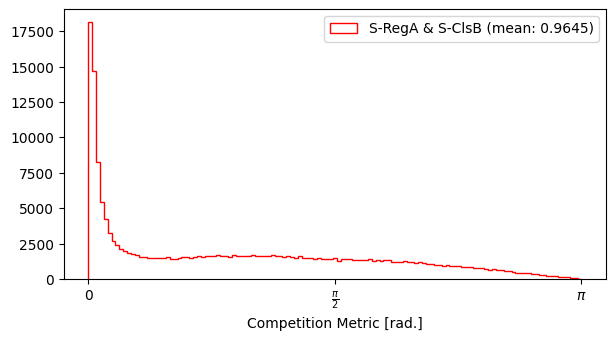

In [ ]:
plot_figure5(preds=preds_655_voted, target=target)

## Fig.6 (a), (b)

In [ ]:
def overlap_ratio(a,b,bins=128):
    hist_a, _ = np.histogram(a, bins=bins)
    hist_b, _ = np.histogram(b, bins=bins)
    overlap_area = np.sum(np.minimum(hist_a, hist_b))
    area_a = np.sum(hist_a)
    overlap_ratio = overlap_area / area_a
    return overlap_ratio

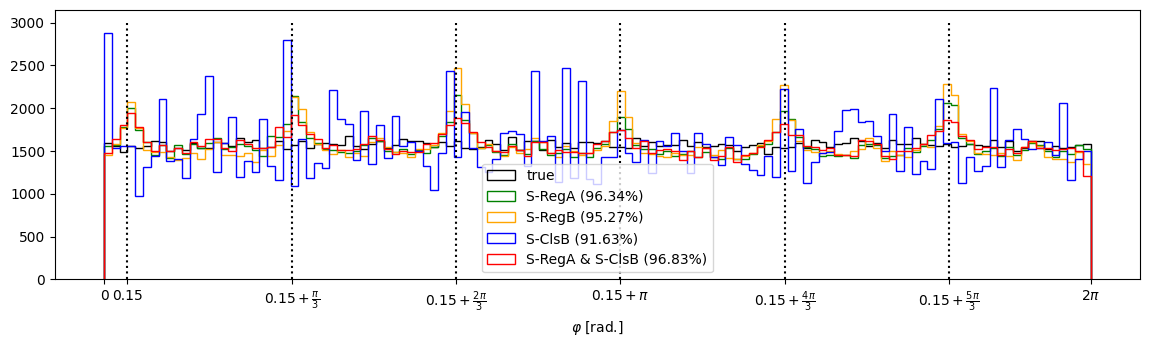

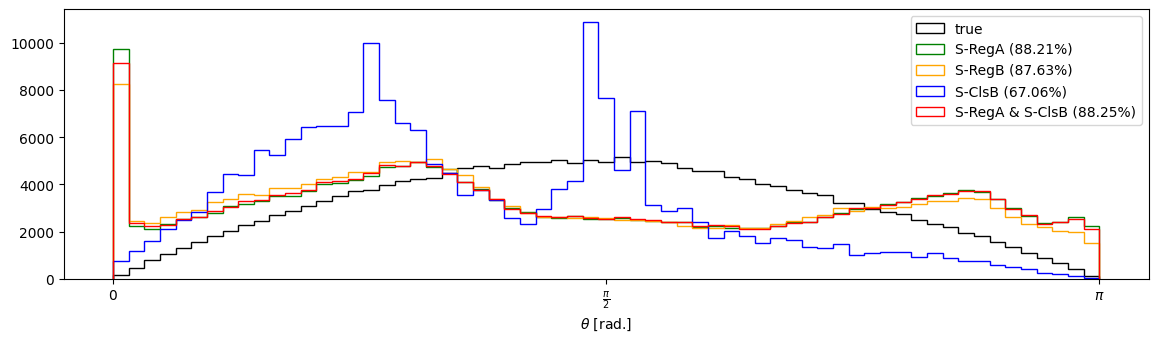

In [ ]:
# azimuth
plt.figure(figsize=(14,3.5))
plt.hist(target[:, 0].numpy(),bins=np.linspace(0,2*np.pi,128),histtype='step',label='true',color='k')
plt.hist(preds_655_RegA[:, 0].numpy(),bins=np.linspace(0,2*np.pi,128),histtype='step',color='g',
         label='S-RegA ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_RegA[:, 0],bins=128)))
plt.hist(preds_655_RegB[:, 0].numpy(),bins=np.linspace(0,2*np.pi,128),histtype='step',color='orange',
         label='S-RegB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_RegB[:, 0],bins=128)))
plt.hist(preds_655_ClsB[:, 0].numpy(),bins=np.linspace(0,2*np.pi,128),histtype='step',color='b',
         label='S-ClsB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_ClsB[:, 0],bins=128)))
plt.hist(preds_655_voted[:, 0].numpy(),bins = np.linspace(0,2*np.pi,128),histtype='step',color='r',
         label='S-RegA & S-ClsB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_voted[:, 0],bins=128)))

start = 3*2*np.pi/128
plt.plot(start * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')
plt.plot((start+np.pi/3) * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')
plt.plot((start+2*np.pi/3) * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')
plt.plot((start+3*np.pi/3) * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')
plt.plot((start+4*np.pi/3) * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')
plt.plot((start+5*np.pi/3) * np.ones(1000), np.linspace(0, 3000, 1000), ':', c='k')

plt.xticks(
    [0,start,start+np.pi/3,start+2*np.pi/3,start+3*np.pi/3,
     start+4*np.pi/3,start+5*np.pi/3,2*np.pi],
    [r"0",r"0.15",r"$0.15+\frac{\pi}{3}$",r"$0.15+\frac{2\pi}{3}$",r"$0.15+\pi$",
     r"$0.15+\frac{4\pi}{3}$",r"$0.15+\frac{5\pi}{3}$",r"$2\pi$"]
)
plt.xlabel(r"$\varphi$"+" [rad.]")
plt.legend(loc="lower center")
plt.show()

# zenith
plt.figure(figsize=(14,3.5))
plt.hist(target[:, 1].numpy(),bins = np.linspace(0,np.pi,64),histtype = 'step',label='true',color='k')
plt.hist(preds_655_RegA[:, 1].numpy(),bins=np.linspace(0,np.pi,64),histtype='step',color='g',
         label='S-RegA ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_RegA[:, 1],bins=64)))
plt.hist(preds_655_RegB[:, 1].numpy(),bins=np.linspace(0,np.pi,64),histtype='step',color='orange',
         label='S-RegB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_RegB[:, 1],bins=64)))
plt.hist(preds_655_ClsB[:, 1].numpy(),bins=np.linspace(0,np.pi,64),histtype='step',color='b',
         label='S-ClsB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_ClsB[:, 1],bins=64)))
plt.hist(preds_655_voted[:, 1].numpy(),bins = np.linspace(0,np.pi,64),histtype = 'step',color='r',
         label='S-RegA & S-ClsB ({:.2%})'.format(overlap_ratio(target[:, 0],preds_655_voted[:, 1],bins=64)))
plt.xticks([0, np.pi/2, np.pi], [r"0", r"$\frac{\pi}{2}$", r"$\pi$"])
plt.xlabel(r"$\theta$"+" [rad.]")
plt.legend()
plt.show()

## Fig.6 (c), (d)

In [ ]:
def plot_figure6(preds, target):
    # calculate difference
    difference = preds.to("cpu") - target.to("cpu")
    difference = difference.numpy()

    df = pd.DataFrame(difference, columns=['azimuthal_error', 'zenithal_error'])

    # sns
    plt.figure(figsize=(7,3.5))
    plt.subplots_adjust(left=0.11, bottom=0.11, right=0.99, top=0.99)
    grid = plt.GridSpec(6, 6, wspace=0.05, hspace=0.05)

    # 2d density
    ax = plt.subplot(grid[1:6,0:5])
    ax.spines[:].set_linewidth(0.4)
    ax = sns.histplot(df, x="azimuthal_error", y="zenithal_error", binwidth=0.06, cmap="Spectral_r")
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax.set_xticklabels([r"$-\pi$", r"$\frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$", r"$\pi$"])
    ax.set_yticks([-np.pi/2, 0, np.pi/2])
    ax.set_yticklabels([r"$- \frac{\pi}{2}$", "0", r"$\frac{\pi}{2}$"])
    ax.set_xlabel(r"$\Delta$"+r"$\varphi$"+" [rad.]")
    ax.set_ylabel(r"$\Delta$"+r"$\theta$"+" [rad.]")
    ax.set_aspect('equal')

    # upper margin
    ax = plt.subplot(grid[0,0:5])
    ax.spines[:].set_linewidth(0.4)
    sns.kdeplot(
        df, x="azimuthal_error", legend=True, ax=ax,
        label=r"$\mu_{\varphi}=$"+f"{difference[:, 0].mean():.4f}, "+r"$\sigma_{\varphi}=$"+f"{difference[:, 0].std():.4f}"
    )
    ax.set_xlim(-np.pi, np.pi)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.legend(frameon = False, handlelength=0.0)

    # right margin
    ax = plt.subplot(grid[1:6,5])
    ax.spines[:].set_linewidth(0.4)
    sns.kdeplot(
        df, y="zenithal_error", legend=True, ax=ax,
        label=r"$\mu_{\theta}=$"+f"{difference[:, 1].mean():.4f},"+f"\n"+r"$\sigma_{\theta}=$"+f"{difference[:, 1].std():.4f}"
    )
    ax.set_ylim(-np.pi/2, np.pi/2)
    ax.set_xticks([])
    ax.set_xlabel("")
    ax.set_yticks([])
    ax.set_ylabel("")
    ax.legend(frameon = False, handlelength=0.0, loc="upper center")

    plt.show()

    # zoom in of figure2
    plt.figure(figsize=(4.5,3.5))
    plt.subplots_adjust(left=0.11, bottom=0.11, right=0.99, top=0.99)
    grid = plt.GridSpec(6, 6, wspace=0.05, hspace=0.05)

    # 2d density
    ax = plt.subplot(grid[1:6,0:5])
    ax.spines[:].set_linewidth(0.4)
    ax = sns.histplot(df, x="azimuthal_error", y="zenithal_error", binwidth=0.02, cmap="Spectral_r", cbar=True)
    ax.set_xlim(-0.2, 0.2)
    ax.set_ylim(-0.2, 0.2)
    ax.set_xlabel(r"$\Delta$"+r"$\varphi$"+" [rad.]")
    ax.set_ylabel(r"$\Delta$"+r"$\theta$"+" [rad.]")

    ax.set_aspect('equal')
    plt.show()

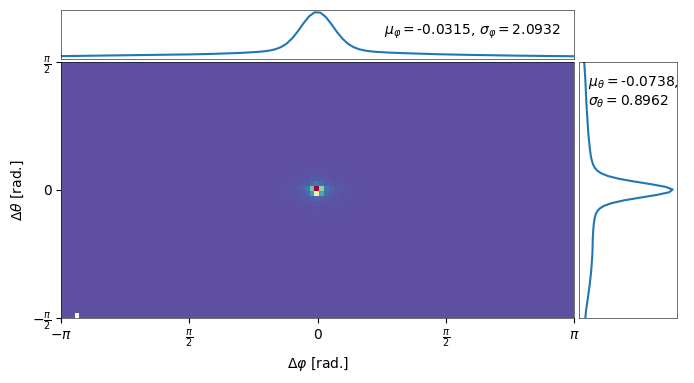

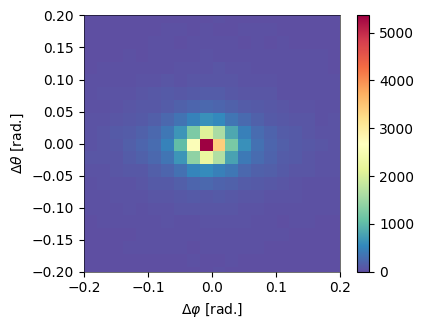

In [ ]:
plot_figure6(preds=preds_655_voted, target=target)